# Lab Deep Learning / Multi-Layer Perceptron for binary-classification / in pytorch


## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and ```relu``` activation functions.
We will perform 10000 iterations (epochs) of SGD to find the parameters.

Note: for this lab, we do not separate the dataset into a train, validation and test part.

### Data normalization

We should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write NN model in pytorch. 

In this lab, we will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2,W3,b3), writing the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. We will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, we will use the ready made loss and optimization from the nn and optim packages.

### Loss

Since we are dealing with a binary classification problem, we will use a Binary Cross Entropy loss (we use ```torch.nn.BCELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.1.

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
 
## Documentation:
- NN: https://pytorch.org/docs/stable/nn.html
- Autograd: https://pytorch.org/docs/stable/autograd.html
- Optim: https://pytorch.org/docs/stable/optim.html


## Load the python packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)

1.6.0+cu101


## Dataset

We take the usual circle dataset from sklearn.

In [ ]:
from sklearn import datasets
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

We convert the ```numpy tensors``` to ```torch tensors```. 
The difference being that the latters allows to do automatic gradient differentiation (back-propagation).

In [ ]:
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
y = y.view(len(y), 1)

In [ ]:
print(X.size())
print(y.size())
print(X.mean(dim=0))
print(X.std(dim=0))

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([-0.0037,  0.0005])
tensor([0.5947, 0.5985])


## Normalization

In [ ]:
X -= X.mean(dim=0)
X /= X.std(dim=0)
print(X.mean(dim=0))
print(X.std(dim=0))

tensor([-3.5763e-09, -1.8120e-08])
tensor([1., 1.])


## Definition of the hyper-parameters

In [ ]:
n_in = X.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1

## Model 1 (writing the network equations)

Here, we will define the variables and write the equations of the network ourselves.
However we will use ```torch tensors``` instead of ```numpy array```. 

***Why ?*** because torch tensors will allows us to automatically get the gradient. We will use ```loss.backward``` to launch the backpropagation from ```loss```. Then, for all tensors we created and for which we declared ```requires_grad=True```, we will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

In [ ]:
# --- We first initialize the variables of the network (W1, b1, ...)
W1 = torch.randn(n_in, n_h1) * 0.01
W1.requires_grad = True
b1 = torch.randn(n_h1, requires_grad=True)

W2 = torch.randn(n_h1, n_h2) * 0.01
W2.requires_grad = True
b2 = torch.randn(n_h2, requires_grad=True)

W3 = torch.randn(n_h2, n_out) * 0.01
W3.requires_grad = True
b3 = torch.randn(n_out, requires_grad=True)


# --- We then write a function to perform the forward pass (using pytorch opertaors, not numpy operators)
# --- taking X as input and returing hat_y as output
    
def model(X):
      A0 = X    
      Z1 = A0.mm(W1) + b1
      A1 = F.relu(Z1)
      Z2 = A1.mm(W2) + b2
      A2 = F.relu(Z2)
      Z3 = A2.mm(W3) + b3
      A3 = torch.sigmoid(Z3) # F.sigmoid
      hat_y = A3
  return hat_y

# --- We then iterate over epochs (we do not perform split into mini-batch here)
# --- For each iteration, we
# ---   a) perform the forward pass, 
# ---   b) compute the loss/cost, 
# ---   c) compute the backward pass to get the gradients of the cost w.r.t. the parameters W1, b1, ...
# ---   d) perform the update of the parameters W1, b1, ...
for num_epoch in range(0, nb_epoch):    

    # --- a) Forward pass: X (n_in, N), hat_y (n_out, N)
    hat_y = model(X)

    # -- We clip hat_y in order to avoid log(0)
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)
    
    # --- b) Computing the loss/cost
    loss = -( y * torch.log(hat_y) + ( 1 - y ) * torch.log(1 - hat_y))
    cost = torch.mean(loss)

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, cost))

    # --- c) Backward pass
    cost.backward()
    
    # --- "with torch.no_grad()" temporarily set all the requires_grad flag to false
    with torch.no_grad():
        # --- d) perform the update of the parameters W1, b1, ...

        # --- the gradients dLoss/dW1 is stored in W1.grad, dLoss/db1 is stored in b1.grad, ...
        W1 -= alpha * W1.grad
        b1 -= alpha * b1.grad
        W2 -= alpha * W2.grad
        b2 -= alpha * b2.grad
        W3 -= alpha * W3.grad
        b3 -= alpha * b3.grad

    # --- We need to set to zero all gradients (otherwise they are cumulated)
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()

epoch 0, loss 0.7047726511955261
epoch 500, loss 0.6931466460227966
epoch 1000, loss 0.6931466460227966
epoch 1500, loss 0.6931464672088623
epoch 2000, loss 0.693146288394928
epoch 2500, loss 0.6931461691856384
epoch 3000, loss 0.6931459307670593
epoch 3500, loss 0.6931458711624146
epoch 4000, loss 0.6931455135345459
epoch 4500, loss 0.6931440234184265
epoch 5000, loss 0.6931401491165161
epoch 5500, loss 0.6931331753730774
epoch 6000, loss 0.6931193470954895
epoch 6500, loss 0.6930903792381287
epoch 7000, loss 0.6930228471755981
epoch 7500, loss 0.6928315758705139
epoch 8000, loss 0.6919697523117065
epoch 8500, loss 0.6748167872428894
epoch 9000, loss 0.5432940721511841
epoch 9500, loss 0.5254406332969666


## Model 2 (using nn.sequential)

Here, we will use the package ```torch.nn``` which comes with a predefined set of layers. The syntax is close to the one of ```keras```(```Sequential```), but differs in the fact that layers are splitted into the matrix multiplication followed by a non-linear activations (```keras```merge both using the ```Dense```layers).

The model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. It is therefore a convenient way to write simple sequential networks.

In [ ]:
my_model = nn.Sequential(
  nn.Linear(X.shape[1], n_h1),
  nn.ReLU(),
  nn.Linear(n_h1, n_h2),
  nn.ReLU(),
  nn.Linear(n_h2, n_out),
  nn.Sigmoid()
  )

## Model 3 (using a class definition)

Here, we will write the network using the recommended pytroch way; i.e. by defining a class.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(n_in, n_h1)  # hidden layer 1
        self.linear2 = nn.Linear(n_h1, n_h2)  # hidden layer 2
        self.linear3 = nn.Linear(n_h2, n_out) # output layer
        
    def forward(self, X):
        A0 = X
        A1 = F.relu(self.linear1(A0))    # activation function for hidden layer 1
        A2 = F.relu(self.linear2(A1))    # activation function for hidden layer 2
        A3 = F.sigmoid(self.linear3(A2)) # activation function for output layer
        return A3

my_model = Net(n_in, n_h1, n_h2, n_out)

## Criterion and Optimization for model 2 and model 3

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forawrd, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update algorithms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

In [ ]:
criterion = nn.BCELoss(weight=None, reduction='mean')
optimizer = optim.SGD(my_model.parameters(), lr=alpha, momentum=0.0)

## Training for model 2 and 3

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0, loss 0.7215383648872375
epoch 500, loss 0.2508355677127838
epoch 1000, loss 0.23880408704280853
epoch 1500, loss 0.23814058303833008
epoch 2000, loss 0.23781944811344147
epoch 2500, loss 0.2375287115573883
epoch 3000, loss 0.23733723163604736
epoch 3500, loss 0.2372179478406906
epoch 4000, loss 0.23701706528663635
epoch 4500, loss 0.2369471788406372
epoch 5000, loss 0.23687951266765594
epoch 5500, loss 0.23682963848114014
epoch 6000, loss 0.23677611351013184
epoch 6500, loss 0.23673272132873535
epoch 7000, loss 0.23667964339256287
epoch 7500, loss 0.2366211861371994
epoch 8000, loss 0.23656870424747467
epoch 8500, loss 0.2365127056837082
epoch 9000, loss 0.2364535629749298
epoch 9500, loss 0.2363935112953186


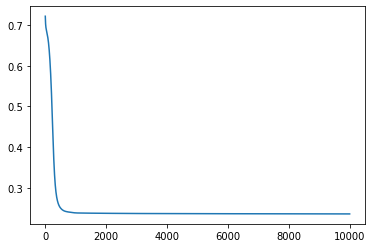

In [ ]:
loss_l = []
for num_epoch in range(nb_epoch):  
    hat_y = my_model(X) # Forward pass: Compute predicted y by passing  x to the model          
    loss = criterion(hat_y, y) # Compute loss 
    # Zero gradients, perform a backward pass, and update the weights. 
    optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
    loss.backward() # perform back-propagation
    optimizer.step() # update the weights
    loss_l.append(loss)

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

plt.plot(loss_l)        